In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import scipy.optimize as opt
from scipy.optimize import LinearConstraint, Bounds
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#reading in orlin's cleaned csv data
local_filepath = "/Users/leonlu/Downloads/gold_data_final.csv" # TODO: I can't import gold_data.csv as a dataframe
gold_data = pd.read_csv(local_filepath, index_col=0)
gold_data = gold_data.iloc[:511, :] #takes care of zero values in AU2208 and AU2210
display(gold_data.head())

,date,AUSHF,dateNoH,ATM_C,OTM_C,ITM_C,ATM_P,OTM_P,ITM_P,tickers
0,2020-05-07 01:00:00,378.00,2020-05-07,7.48,5.70,10.10,5.98,4.28,8.24,AU2006
1,2020-05-08 01:00:00,381.86,2020-05-08,6.90,5.16,8.96,5.32,3.68,7.66,AU2006
2,2020-05-09 01:00:00,381.68,2020-05-09,6.76,4.80,9.22,5.26,3.56,7.06,AU2006
3,2020-05-12 01:00:00,380.32,2020-05-12,5.20,3.74,7.66,5.26,3.58,7.86,AU2006
4,2020-05-13 01:00:00,380.70,2020-05-13,5.10,3.50,7.78,4.22,2.82,6.96,AU2006


In [3]:
#data processing to remove jumps due to changing option expiries
gold_data = gold_data.drop(columns=['dateNoH'])
gold_dfs_by_expiry = gold_data.groupby('tickers')
gold_df_array = []
num_expiries = len(gold_dfs_by_expiry)
for _, group in gold_dfs_by_expiry:
    gold_df_array.append(group)

In [4]:
#construct reward matrix R_{i,t} of dimension (K x N)
def generate_reward_matrix(df):
    reward_df = df.iloc[:, -8:-1].pct_change()
    reward_df.dropna(how = 'all', inplace = True)
    reward_df.drop(reward_df.index[-1], inplace=True) #drops the last line of data
    return reward_df
reward_df_array = []
for df in gold_df_array:
    reward_df_array.append(generate_reward_matrix(df))

### Implementation of Huo and Fu begins here

In [5]:
# define helper functions used in huo/fu paper
def get_arm_weights(i, K):
    if i == 0:
        return np.ones(K)/K #equal weight, positive
    elif i == 1:
        return -np.ones(K)/K #equal weight, negative
    elif i == 2:
        return [1/3,-2/3,0,0,0,0,0] #buy future, sell 2 calls
    elif i == 3:
        return [1/3,0,0,0,2/3,0,0] #buy future, buy 2 puts
    elif i == 4:
        return np.zeroes(K)
        
def I(t, K, R, times_selected):
    """
    Definition: Equation 2.1
    """
    if t < 5: # strict inequality due to assets being 0, 1, ..., K-1
        selection = t
    else:
        R_bar = R[:t].mean(axis=0) # take the mean across the time axis
        R_bar = R_bar.to_numpy()
        selection = np.argmax([R_bar[i] + np.sqrt((2 * np.log(t) / times_selected[i])) for i in range(5)])
    times_selected[selection] += 1
    return selection
        
def F(t, H, R, u, alpha_, gamma_, delta_):
    """
    Definition: Equation 2.3; estimates the conditional value-at-risk.
    H_matrix: the s-th column of H_matrix (K rows, \delta columns) is the historical returns of the s-th asset
    R_matrix: the s-th column of R_matrix (K rows, t - 1 columns) is the trial of returns observed so far of the s-th asset
    """
    sum1 = np.sum([np.max(-np.dot(H.iloc[s, :], u) - alpha_, 0) for s in range(len(H))])
    sum2 = np.sum([np.max(-np.dot(R.iloc[s, :], u) - alpha_, 0) for s in range(t-1)])
    return alpha_ + (sum1 + sum2) / ((delta_ + t - 1) * (1 - gamma_))

In [6]:
def omega_C(t, K, H, R, gamma_, delta_, equal_weights=False):
    """
    Definition: Equation 2.4
    Computes a risk-aware portfolio according to Equation 2.3. 
    t: the time
    """
    def sum_constraint(u):
        return np.sum(u) - 1
    def non_negative_constraint(u):
        return u
    
    alpha_ = 0.05
    constraints = [{'type': 'eq', 'fun': sum_constraint}, 
                   {'type': 'ineq', 'fun': non_negative_constraint}]
    initial_guess = np.ones(K)/K
    
    if equal_weights:
        return initial_guess
    else:
        result = opt.minimize(
            fun = lambda u: F(t, H, R, u, alpha_, gamma_, delta_),
            x0 = initial_guess,
            constraints = constraints
        )

        # NOTE: Winston 12/06 9:04pm: here is some code for optimizing F w.r.t. (u, alpha), where alpha is instead 
        # from a bounded interval. min_price and max_price are the min. and max. prices of any asset in the historical 
        # returns matrix.
        # 
        # The main difference between this code and yours is that F_t takes (u, alpha) as an argument, not just u, 
        # which is what you've implemented.
        # 
        # [(0, 1)] * K are the bounds for the weights; (min_price, max_price) is for alpha
        # nonnegative_bounds = [(0, 1)] * K + [(min_price, max_price)]
        # nonnegative_constraints = lambda x: np.sum(x[:K]) - 1
        #
        # bounds for weights are (-1, 1) since now we allow negative proportions for the weights in u. 
        # absolute_bounds = [(-1, 1)] * K + [(min_price, max_price)]
        # absolute_constraints = lambda x: np.sum(abs(x[:K])) - 1
        # 
        # result = opt.minimize(
        #     F_t, x0 = x0,
        #     constraints = [{'type': 'eq', 'fun': nonnegative_constraints}], # NOTE: can be changed to absolute_constraints
        #     bounds = nonnegative_bounds # NOTE: can be changed to absolute_bounds
        # )
        return result.x

In [7]:
def sequential_selection_algo(K, H, R, lambda_, gamma_, delta_, times_selected, equal_weights = False):
    """
    K: number of assets
    gamma: confidence level
    lambda_: risk preference
    """
    weights = []
    for t in range(len(R)):
        # Equation. 2.2: compute omega_M(t)
        
        omega_M = np.zeros(K) 
        omega_M[I(t, K, R, times_selected)] = 1
        
        # Equation 2.4: compute the risk aware portfolio
        risk_aware_portfolio = omega_C(t, K, H, R, gamma_, delta_, equal_weights)

        # Equation 2.5: compute convex combination of UCB1 portfolio and risk aware portfolio
        omega_star = lambda_ * omega_M + (1 - lambda_) * risk_aware_portfolio
        # "Receive portfolio reward"
        weights.append(omega_star)
    return weights

In [8]:
"""
Main function to find rewards from Huo/Fu algorithm. 

:param rolling_window: size of window to propagate tests on 
:param lambda_: risk aversity [0,1]
:param gamma_: CVaR confidence level [0,1]
:param K: number of assets
"""
def get_cumulative_rewards(rolling_window, lambda_=0.5, gamma_=0.95, K=7, equal_weights=False):
    cumulative_reward = []
    cycle_count = 0
    cumulative_cycle_arr = []
    for i in tqdm(range(num_expiries - rolling_window)):
        training_sets = reward_df_array[i:i+rolling_window-1]
        test_set = reward_df_array[i+rolling_window]
        historical_set = training_sets[0]

        training_weights = []
        for i, train_set in tqdm(enumerate(training_sets)):
            times_selected = np.zeros(K)
            if i == 0:
                continue
            set_weight = sequential_selection_algo(K, historical_set, test_set, lambda_, 
                                                   gamma_, len(historical_set), times_selected, equal_weights)
            training_weights.append(set_weight)
            historical_set = pd.concat([historical_set, train_set], ignore_index=True)
        stacked_weights = np.stack(training_weights, axis=2)
        mean_training_weights = np.mean(stacked_weights, axis=2)
        curr_cycle_reward = 0
        curr_cycle_arr = []
        np_test_set = test_set.to_numpy()
        for t in range(min(len(mean_training_weights), len(np_test_set))):
            curr_cycle_reward += np.dot(mean_training_weights[t], np_test_set[t])
            curr_cycle_arr.append(curr_cycle_reward)
        cumulative_reward.append(curr_cycle_reward)
        cumulative_cycle_arr.append(curr_cycle_arr)
        cycle_count += 1
    return cumulative_reward, cumulative_cycle_arr

In [9]:
test_reward_info = get_cumulative_rewards(5)

  0%|          | 0/9 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:02,  1.06s/it]
3it [00:07,  3.00s/it]
4it [00:18,  4.53s/it]
 11%|█         | 1/9 [00:18<02:24, 18.11s/it]
0it [00:00, ?it/s]
2it [00:05,  2.92s/it]
3it [00:17,  6.40s/it]
4it [00:29,  7.36s/it]
 22%|██▏       | 2/9 [00:47<02:53, 24.77s/it]
0it [00:00, ?it/s]
2it [00:09,  4.99s/it]
3it [00:20,  7.15s/it]
4it [00:34,  8.58s/it]
 33%|███▎      | 3/9 [01:21<02:54, 29.13s/it]
0it [00:00, ?it/s]
2it [00:05,  2.62s/it]
3it [00:12,  4.73s/it]
4it [00:23,  5.84s/it]
 44%|████▍     | 4/9 [01:45<02:14, 26.85s/it]
0it [00:00, ?it/s]
2it [00:05,  2.65s/it]
3it [00:12,  4.37s/it]
4it [00:21,  5.38s/it]
 56%|█████▌    | 5/9 [02:06<01:39, 24.92s/it]
0it [00:00, ?it/s]
2it [00:05,  2.64s/it]
3it [00:13,  4.80s/it]
4it [00:23,  5.99s/it]
 67%|██████▋   | 6/9 [02:30<01:13, 24.60s/it]
0it [00:00, ?it/s]
2it [00:05,  2.59s/it]
3it [00:14,  5.31s/it]
4it [00:26,  6.65s/it]
 78%|███████▊  | 7/9 [02:57<00:50, 25.26s/it]
0it [00:00, ?it/s]
2it [

In [18]:
def plot_mean_rewards(reward_arr, title='', filename='vanilla.png'):
    for i, r in enumerate(reward_arr):
        time_steps = np.arange(0, len(r), 1)
        values = [x * 100 for x in r]
        plt.plot(time_steps, values, marker='o', label= 'Trial' + str(i))
    plt.title('Mean Rewards Over Time: ' + title)
    plt.xlabel('Time Steps (days)')
    plt.ylabel('Mean Reward (%change)')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

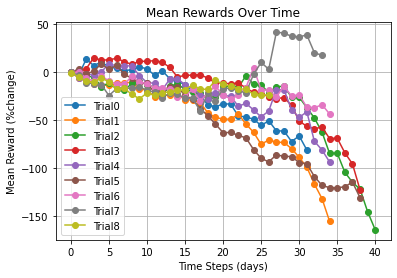

In [11]:
plot_mean_rewards(test_reward_info[1])

In [23]:
print(np.mean(test_reward_info[0])/40)

-0.02216298215965801


  0%|          | 0/9 [00:00<?, ?it/s]
4it [00:00, 108.77it/s]

4it [00:00, 108.53it/s]

4it [00:00, 99.56it/s]
 33%|███▎      | 3/9 [00:00<00:00, 24.50it/s]
4it [00:00, 113.26it/s]

4it [00:00, 118.85it/s]

4it [00:00, 101.95it/s]
 67%|██████▋   | 6/9 [00:00<00:00, 25.22it/s]
4it [00:00, 109.30it/s]

4it [00:00, 119.80it/s]

4it [00:00, 154.72it/s]
100%|██████████| 9/9 [00:00<00:00, 26.16it/s]


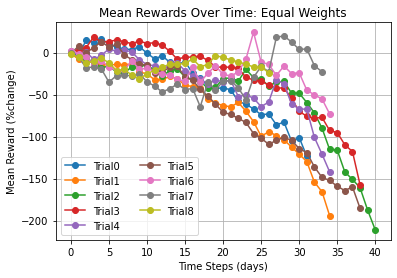

-0.03148379951699219


In [22]:
equal_weights_info = get_cumulative_rewards(5, 0.5, 0.95, 7, True)
plot_mean_rewards(equal_weights_info[1], 'Equal Weights', 'equal_weights.png')
equal_weights_rewards = equal_weights_info[0]
print(np.mean(equal_weights_rewards)/40)

In [12]:
K = 6 #number of peripheral assets (non AUSHF) in market
gamma_ = 0.95 #confidence level for CVaR performance function F
split_prop = 0.8 #train/test split
#N = len(reward_df) #number of rows/timestep data
#delta_ = int(split_prop * N) #delta in calculation
lambda_ = 0.5 # risk preference (->1 means UCB1, ->0 means min CVaR)


# NOTE: Winston (12/06 9:01pm): if you just want to see what happens when you can only trade L < K assets at a time, pick L 
# assets and make a Boolean array whose i-th component is True if you want to trade asset i and is False otherwise. For example,
# if you want to trade assets 1 and 3, then the array is [False, True, False, True, False, False]. Then slice
# H_matrix and R_matrix with that Boolean array along the asset dimension (the columns) so that the dimension only contains the
# assets you want to trade, and proceed as normal.